<a href="https://colab.research.google.com/github/klobell/phone-ban-sc/blob/main/phone_ban_synthetic_control.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Data Loading and Cleaning**


In [19]:
import pandas as pd
import glob

# Step 1: Load and clean all files
files = sorted(glob.glob("sb_ca20*_1_csv_*.txt"))

dfs = []
for f in files:
    try:
        year = int(f.split('_')[1][2:6])

        if year <= 2019:
            sep = ","
        else:
            sep = "^"

        df = pd.read_csv(f, sep=sep, engine="python", encoding="cp1252", on_bad_lines="skip")

        # Standardize column names between old and new files
        column_mapping = {
            'Subgroup ID': 'Student Group ID',
            'Test Id': 'Test ID',
            'Students Tested': 'Total Students Tested',
            'Students with Scores': 'Total Students Tested with Scores'
        }

        df.rename(columns=column_mapping, inplace=True)

        # Consolidate enrollment columns - use the first non-null value
        # Priority: CAASPP Reported Enrollment > Students Enrolled > Total Students Enrolled
        if 'CAASPP Reported Enrollment' in df.columns:
            df['Enrollment'] = df['CAASPP Reported Enrollment']
        elif 'Students Enrolled' in df.columns:
            df['Enrollment'] = df['Students Enrolled']
        elif 'Total Students Enrolled' in df.columns:
            df['Enrollment'] = df['Total Students Enrolled']

        # Also try to fill from multiple sources
        if 'Enrollment' not in df.columns:
            df['Enrollment'] = None

        for col in ['CAASPP Reported Enrollment', 'Students Enrolled', 'Total Students Enrolled']:
            if col in df.columns:
                df['Enrollment'] = df['Enrollment'].fillna(df[col])

        dfs.append(df)

    except Exception as e:
        print(f"Error reading {f}: {e}")
        continue

# Step 2: Concatenate and apply basic filters
df_full = pd.concat(dfs, ignore_index=True)

print(f"Before filtering: {len(df_full)} rows")

df_full = df_full[df_full["Student Group ID"] == 1]
print(f"After Student Group ID filter: {len(df_full)} rows")

df_full = df_full[df_full["Test ID"].isin([1.0, 2.0])]
print(f"After Test ID filter: {len(df_full)} rows")

df_full = df_full[df_full["Grade"] == 11]
print(f"After Grade filter: {len(df_full)} rows")

# Step 3: Define your schools
treated_school = "San Mateo High"
treatment_year = 2019

donor_schools = [
    "Burlingame High",
    "Hillsdale High",
    "Aragon High",
    "Mills High",
    "Capuchino High",
    "Sequoia High",
    "Menlo-Atherton High",
    "Carlmont High",
    "Henry M. Gunn High",
    "Palo Alto High"
]

# Step 4: Get school codes from 2024 data
school_codes = {}

for school in [treated_school] + donor_schools:
    school_info = df_full[(df_full['School Name'] == school) & (df_full['Test Year'] == 2024)]
    if len(school_info) > 0:
        code = school_info[['District Code', 'School Code']].iloc[0]
        school_codes[school] = (code['District Code'], code['School Code'])

# Step 5: Filter by school codes and add school names
filtered_dfs = []

for school_name, (district_code, school_code) in school_codes.items():
    school_data = df_full[
        (df_full['District Code'] == district_code) &
        (df_full['School Code'] == school_code)
    ].copy()

    school_data.loc[:, 'School Name'] = school_name
    filtered_dfs.append(school_data)

df = pd.concat(filtered_dfs, ignore_index=True)

print(f"\n{'='*60}")
print(f"Final filtered dataframe shape: {df.shape}")
print(f"\nYears in data:")
print(df['Test Year'].value_counts().sort_index())
print(f"\nSchools in data:")
print(df['School Name'].value_counts())

# Verify the data is now aligned
print("\n\nVerifying key columns have data across all years:")
print(df.groupby('Test Year')[['Total Students Tested', 'Enrollment', 'Mean Scale Score']].count())

Before filtering: 1020502 rows
After Student Group ID filter: 1020502 rows
After Test ID filter: 1020502 rows
After Grade filter: 65999 rows

Final filtered dataframe shape: (220, 82)

Years in data:
Test Year
2015    22
2016    22
2017    22
2018    22
2019    22
2021    22
2022    22
2023    22
2024    22
2025    22
Name: count, dtype: int64

Schools in data:
School Name
San Mateo High         20
Burlingame High        20
Hillsdale High         20
Aragon High            20
Mills High             20
Capuchino High         20
Sequoia High           20
Menlo-Atherton High    20
Carlmont High          20
Henry M. Gunn High     20
Palo Alto High         20
Name: count, dtype: int64


Verifying key columns have data across all years:
           Total Students Tested  Enrollment  Mean Scale Score
Test Year                                                     
2015                          22          22                22
2016                          22          22                22
2017    

In [20]:
# Remove 2021 from your analysis since testing was suspended
df = df[df['Test Year'] != 2021]

print(f"Analysis dataframe (excluding 2021): {df.shape}")
print(f"\nYears in analysis:")
print(df['Test Year'].value_counts().sort_index())

# Verify all years now have complete data (just counts, no means)
print("\n\nData completeness check:")
print(df.groupby('Test Year')[['Total Students Tested', 'Enrollment', 'Mean Scale Score']].count())

# Check data types
print("\n\nColumn data types:")
print(f"Total Students Tested: {df['Total Students Tested'].dtype}")
print(f"Enrollment: {df['Enrollment'].dtype}")
print(f"Mean Scale Score: {df['Mean Scale Score'].dtype}")

# Check if Mean Scale Score has any non-numeric values
print("\n\nChecking for non-numeric values in Mean Scale Score:")
non_numeric = df[pd.to_numeric(df['Mean Scale Score'], errors='coerce').isna() & df['Mean Scale Score'].notna()]
if len(non_numeric) > 0:
    print(f"Found {len(non_numeric)} rows with non-numeric Mean Scale Score values:")
    print(non_numeric[['Test Year', 'School Name', 'Mean Scale Score']].head(10))
else:
    print("All Mean Scale Score values are numeric or NaN")

Analysis dataframe (excluding 2021): (198, 82)

Years in analysis:
Test Year
2015    22
2016    22
2017    22
2018    22
2019    22
2022    22
2023    22
2024    22
2025    22
Name: count, dtype: int64


Data completeness check:
           Total Students Tested  Enrollment  Mean Scale Score
Test Year                                                     
2015                          22          22                22
2016                          22          22                22
2017                          22          22                22
2018                          22          22                22
2019                          22          22                22
2022                          22          22                22
2023                          22          22                22
2024                          22          22                22
2025                          22          22                22


Column data types:
Total Students Tested: object
Enrollment: object
Mean Sca

In [21]:
df["School Name"].unique() # check we got all treated and donor units in filtered df

array(['San Mateo High', 'Burlingame High', 'Hillsdale High',
       'Aragon High', 'Mills High', 'Capuchino High', 'Sequoia High',
       'Menlo-Atherton High', 'Carlmont High', 'Henry M. Gunn High',
       'Palo Alto High'], dtype=object)

In [22]:
df.iloc[10:20, 40:50]  # looking at some lines

,Total Tested with Scores at Reporting Level,Students Enrolled,Type ID,District Name,School Name,Total Students Enrolled,Count Standard Exceeded,Count Standard Met,Count Standard Met and Above,Count Standard Nearly Met
12,316,392,7.0,NaN,San Mateo High,NaN,NaN,NaN,NaN,NaN
13,330,392,7.0,NaN,San Mateo High,NaN,NaN,NaN,NaN,NaN
14,388,447,7.0,NaN,San Mateo High,NaN,NaN,NaN,NaN,NaN
15,407,447,7.0,NaN,San Mateo High,NaN,NaN,NaN,NaN,NaN
16,NaN,NaN,7.0,San Mateo Union High,San Mateo High,377,123,91,214,38
17,NaN,NaN,7.0,San Mateo Union High,San Mateo High,377,95,37,132,51
18,NaN,NaN,7.0,San Mateo Union High,San Mateo High,359,118,70,188,54
19,NaN,NaN,7.0,San Mateo Union High,San Mateo High,359,74,54,128,46
20,NaN,NaN,NaN,NaN,Burlingame High,NaN,NaN,NaN,NaN,NaN
21,NaN,NaN,NaN,NaN,Burlingame High,NaN,NaN,NaN,NaN,NaN


In [23]:
# split up df into ela and math

ela  = df[df["Test ID"] == 1]
math = df[df["Test ID"] == 2]

# Export cleaned data for analysis
ela.to_csv('ela_cleaned.csv', index=False)
math.to_csv('math_cleaned.csv', index=False)

In [24]:
ela.head()

,County Code,District Code,School Code,Filler,Test Year,Student Group ID,Test Type,Total CAASPP Enrollment,Total Tested At Entity Level,Total Tested at Subgroup Level,...,Composite Area 1 Percentage Below Standard,Composite Area 1 Count Below Standard,Composite Area 1 Total,Composite Area 2 Percentage Above Standard,Composite Area 2 Count Above Standard,Composite Area 2 Percentage Near Standard,Composite Area 2 Count Near Standard,Composite Area 2 Percentage Below Standard,Composite Area 2 Count Below Standard,Composite Area 2 Total
1,41,69047,4136370,NaN,2015,1,B,782.0,754,754.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,41,69047,4136370,NaN,2016,1,B,391.0,361,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,41,69047,4136370,NaN,2017,1,B,NaN,338,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,41,69047,4136370,NaN,2018,1,B,NaN,334,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,41,69047,4136370,NaN,2019,1,B,NaN,385,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
math.head()

,County Code,District Code,School Code,Filler,Test Year,Student Group ID,Test Type,Total CAASPP Enrollment,Total Tested At Entity Level,Total Tested at Subgroup Level,...,Composite Area 1 Percentage Below Standard,Composite Area 1 Count Below Standard,Composite Area 1 Total,Composite Area 2 Percentage Above Standard,Composite Area 2 Count Above Standard,Composite Area 2 Percentage Near Standard,Composite Area 2 Count Near Standard,Composite Area 2 Percentage Below Standard,Composite Area 2 Count Below Standard,Composite Area 2 Total
0,41,69047,4136370,NaN,2015,1,B,782.0,754,754.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,41,69047,4136370,NaN,2016,1,B,391.0,377,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,41,69047,4136370,NaN,2017,1,B,NaN,342,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,41,69047,4136370,NaN,2018,1,B,NaN,335,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,41,69047,4136370,NaN,2019,1,B,NaN,398,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Splitting up into math and ela matrices using "percentage standard met"

In [26]:
# Convert percentage columns to numeric
percentage_cols = [col for col in df.columns if 'Percentage' in col]

for col in percentage_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Also convert other important numeric columns
numeric_cols = ['Mean Scale Score', 'Total Students Tested', 'Enrollment']
for col in numeric_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

print("Converted columns to numeric")

# Now split and pivot
ela  = df[df["Test ID"] == 1]
math = df[df["Test ID"] == 2]

mathpanel = math.pivot_table(
    index="School Name",
    columns="Test Year",
    values="Percentage Standard Met"
)

elapanel = ela.pivot_table(
    index="School Name",
    columns="Test Year",
    values="Percentage Standard Met"
)

print("\nMath Panel:")
print(mathpanel)

print("\nELA Panel:")
print(elapanel)

Converted columns to numeric

Math Panel:
Test Year            2015  2016   2017   2018   2019   2022   2023   2024  \
School Name                                                                 
Aragon High          24.0  25.0  26.85  20.38  20.55  25.00  21.01  19.67   
Burlingame High      31.0  32.0  23.69  27.73  26.93  21.27  21.58  26.62   
Capuchino High       23.0  26.0  23.79  22.96  20.13  14.52  21.43  13.73   
Carlmont High        24.0  26.0  27.02  27.82  27.13  22.18  22.71  20.07   
Henry M. Gunn High   12.0  18.0  16.49  17.22  14.89  17.20  16.59  13.82   
Hillsdale High       22.0  29.0  28.61  25.48  28.62  22.65  20.49  17.66   
Menlo-Atherton High  17.0  18.0  21.75  18.00  19.58  18.95  16.46  15.04   
Mills High           28.0  26.0  23.86  22.91  25.69  23.14  20.00  29.01   
Palo Alto High       14.0  18.0  16.13  10.45  18.78  12.20  15.59  16.96   
San Mateo High       22.0  26.0  21.13  23.65  18.84  16.97  15.97  12.01   
Sequoia High         18.0  24.0  2

## **Synthetic Control Analysis**


In [33]:
pip install toolz

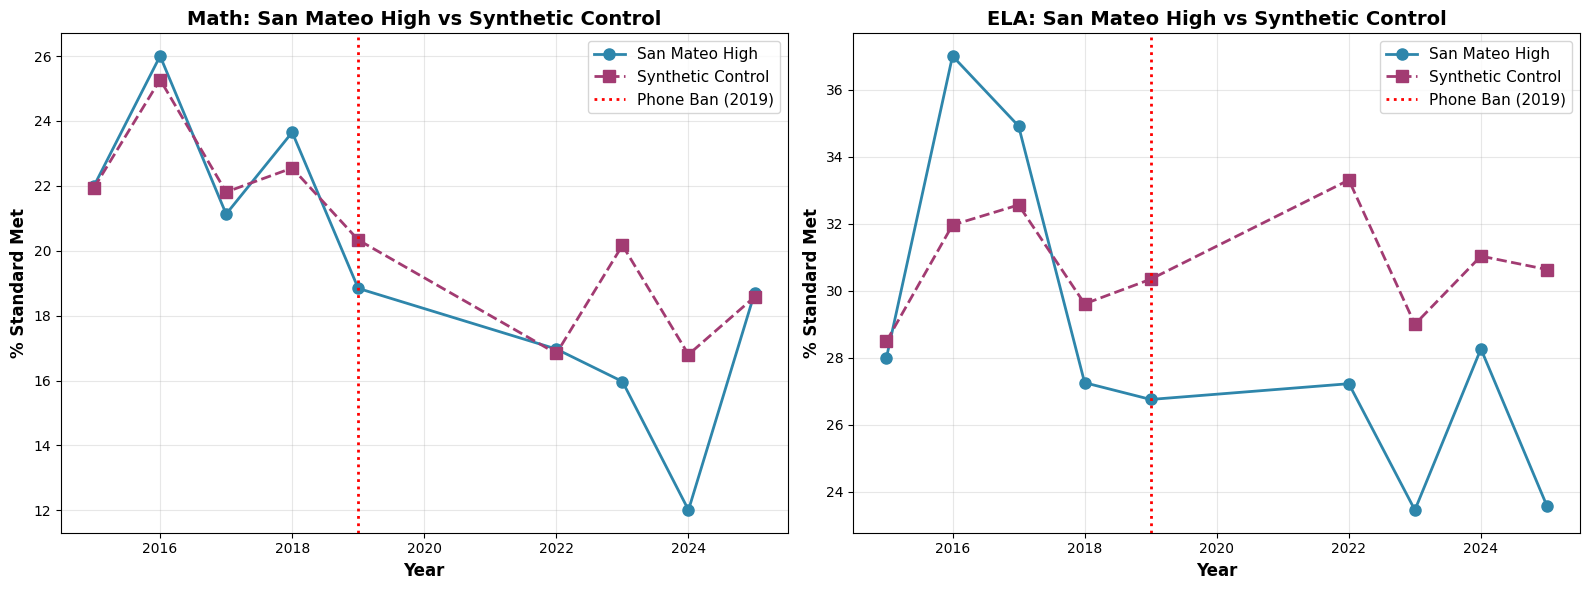

=== MATH WEIGHTS ===
Burlingame High: 0.2364
Capuchino High: 0.4955
Henry M. Gunn High: 0.2681

=== ELA WEIGHTS ===
Capuchino High: 0.1221
Hillsdale High: 0.3964
Mills High: 0.2098
Sequoia High: 0.2717

=== TREATMENT EFFECTS (Post-2019) ===
Math:
  2022: 0.14 percentage points
  2023: -4.20 percentage points
  2024: -4.79 percentage points
  2025: 0.12 percentage points

ELA:
  2022: -6.08 percentage points
  2023: -5.54 percentage points
  2024: -2.77 percentage points
  2025: -7.06 percentage points


In [27]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import fmin_slsqp
from toolz import partial
import pandas as pd

#####################################
#### Helper functions
#####################################

def loss_w(W, X, y) -> float:
    return np.sqrt(np.mean((y - X.dot(W))**2))

def get_w(X, y):
    w_start = [1/X.shape[1]]*X.shape[1]
    weights = fmin_slsqp(partial(loss_w, X=X, y=y),
                         np.array(w_start),
                         f_eqcons=lambda x: np.sum(x) - 1,
                         bounds=[(0.0, 1.0)]*len(w_start),
                         disp=False)
    return weights

#####################################
#### Analysis
#####################################

# Remove 2021 (COVID year)
mathpanel_clean = mathpanel.drop(columns=[2021], errors='ignore')
elapanel_clean = elapanel.drop(columns=[2021], errors='ignore')

# Settings
treated_school = "San Mateo High"
treatment_year = 2019
pre_treatment_years = [2015, 2016, 2017, 2018, 2019]
all_years = mathpanel_clean.columns.tolist()

# Get donor schools
donor_schools_list = [school for school in mathpanel_clean.index if school != treated_school]

#####################################
#### MATH
#####################################

# Prepare data
X_math = mathpanel_clean.loc[donor_schools_list, pre_treatment_years].T.values
y_math = mathpanel_clean.loc[treated_school, pre_treatment_years].values

# Get weights
math_weights = get_w(X_math, y_math)

# Create synthetic control for all years
synthetic_math = mathpanel_clean.loc[donor_schools_list].T.dot(math_weights)
actual_math = mathpanel_clean.loc[treated_school]

#####################################
#### ELA
#####################################

# Prepare data
X_ela = elapanel_clean.loc[donor_schools_list, pre_treatment_years].T.values
y_ela = elapanel_clean.loc[treated_school, pre_treatment_years].values

# Get weights
ela_weights = get_w(X_ela, y_ela)

# Create synthetic control for all years
synthetic_ela = elapanel_clean.loc[donor_schools_list].T.dot(ela_weights)
actual_ela = elapanel_clean.loc[treated_school]

#####################################
#### PLOT
#####################################

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Math plot
ax1.plot(all_years, actual_math, 'o-', linewidth=2, markersize=8, label='San Mateo High', color='#2E86AB')
ax1.plot(all_years, synthetic_math, 's--', linewidth=2, markersize=8, label='Synthetic Control', color='#A23B72')
ax1.axvline(x=treatment_year, color='red', linestyle=':', linewidth=2, label='Phone Ban (2019)')
ax1.set_xlabel('Year', fontsize=12, fontweight='bold')
ax1.set_ylabel('% Standard Met', fontsize=12, fontweight='bold')
ax1.set_title('Math: San Mateo High vs Synthetic Control', fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# ELA plot - let it auto-scale
ax2.plot(all_years, actual_ela, 'o-', linewidth=2, markersize=8, label='San Mateo High', color='#2E86AB')
ax2.plot(all_years, synthetic_ela, 's--', linewidth=2, markersize=8, label='Synthetic Control', color='#A23B72')
ax2.axvline(x=treatment_year, color='red', linestyle=':', linewidth=2, label='Phone Ban (2019)')
ax2.set_xlabel('Year', fontsize=12, fontweight='bold')
ax2.set_ylabel('% Standard Met', fontsize=12, fontweight='bold')
ax2.set_title('ELA: San Mateo High vs Synthetic Control', fontsize=14, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)
# No y-limit set - let it auto-scale

plt.tight_layout()
plt.show()

# Print weights
print("=== MATH WEIGHTS ===")
pos_weights_idx = np.where(math_weights > 0.01)[0]
for idx in pos_weights_idx:
    print(f"{donor_schools_list[idx]}: {math_weights[idx]:.4f}")

print("\n=== ELA WEIGHTS ===")
pos_weights_idx = np.where(ela_weights > 0.01)[0]
for idx in pos_weights_idx:
    print(f"{donor_schools_list[idx]}: {ela_weights[idx]:.4f}")

# Print treatment effects
print("\n=== TREATMENT EFFECTS (Post-2019) ===")
post_years = [2022, 2023, 2024, 2025]
print("Math:")
for year in post_years:
    diff = actual_math[year] - synthetic_math[year]
    print(f"  {year}: {diff:.2f} percentage points")

print("\nELA:")
for year in post_years:
    diff = actual_ela[year] - synthetic_ela[year]
    print(f"  {year}: {diff:.2f} percentage points")

### Check Model RMSPE

In [34]:
# Check RMSPE (Root Mean Squared Prediction Error) pre-treatment - Math
pre_treatment_years = [2015, 2016, 2017, 2018, 2019]
donor_schools = [s for s in mathpanel_clean.index if s != "San Mateo High"]
X = mathpanel_clean.loc[donor_schools, pre_treatment_years].T.values
y = mathpanel_clean.loc["San Mateo High", pre_treatment_years].values
weights = get_w(X, y)
synthetic_pre = mathpanel_clean.loc[donor_schools, pre_treatment_years].T.dot(weights)

rmspe_pre = np.sqrt(np.mean((y - synthetic_pre)**2))
print(f"Math Pre-treatment RMSPE: {rmspe_pre:.3f}")
print(f"Average of actual values: {np.mean(y):.2f}")
print(f"RMSPE as % of mean: {100*rmspe_pre/np.mean(y):.1f}%")

Math Pre-treatment RMSPE: 0.942
Average of actual values: 22.32
RMSPE as % of mean: 4.2%


In [32]:
# Check RMSPE (Root Mean Squared Prediction Error) pre-treatment - ELA
pre_treatment_years = [2015, 2016, 2017, 2018, 2019]
donor_schools = [s for s in elapanel_clean.index if s != "San Mateo High"]
X = elapanel_clean.loc[donor_schools, pre_treatment_years].T.values
y = elapanel_clean.loc["San Mateo High", pre_treatment_years].values
weights = get_w(X, y)
synthetic_pre = elapanel_clean.loc[donor_schools, pre_treatment_years].T.dot(weights)

rmspe_pre = np.sqrt(np.mean((y - synthetic_pre)**2))
print(f"ELA Pre-treatment RMSPE: {rmspe_pre:.3f}")
print(f"Average of actual values: {np.mean(y):.2f}")
print(f"RMSPE as % of mean: {100*rmspe_pre/np.mean(y):.1f}%")

ELA Pre-treatment RMSPE: 3.151
Average of actual values: 30.78
RMSPE as % of mean: 10.2%


### Math Placebo Tests

San Mateo High treatment effect: -2.18 percentage points
P-value: 0.182


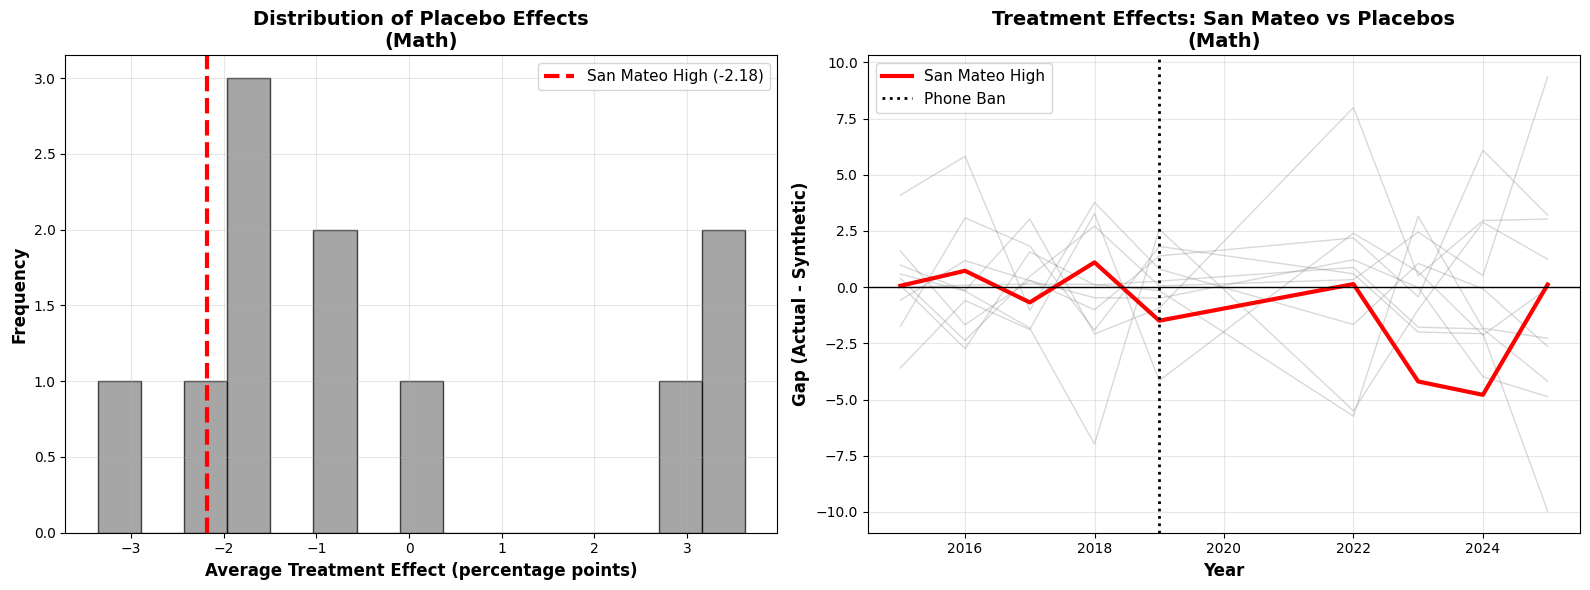


=== All Placebo Effects (Math) ===
Aragon High: 3.62
Carlmont High: 3.16
Mills High: 2.76
Henry M. Gunn High: 0.22
Palo Alto High: -0.59
Burlingame High: -0.83
Capuchino High: -1.67
Menlo-Atherton High: -1.74
Sequoia High: -1.91
San Mateo High: -2.18 <-- San Mateo High
Hillsdale High: -3.36


In [31]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fmin_slsqp
from toolz import partial
import pandas as pd

# Helper functions
def loss_w(W, X, y):
    return np.sqrt(np.mean((y - X.dot(W))**2))

def get_w(X, y):
    w_start = [1/X.shape[1]]*X.shape[1]
    weights = fmin_slsqp(partial(loss_w, X=X, y=y),
                         np.array(w_start),
                         f_eqcons=lambda x: np.sum(x) - 1,
                         bounds=[(0.0, 1.0)]*len(w_start),
                         disp=False)
    return weights

# Settings
mathpanel_clean = mathpanel.drop(columns=[2021], errors='ignore')
treated_school = "San Mateo High"
pre_treatment_years = [2015, 2016, 2017, 2018, 2019]
post_treatment_years = [2022, 2023, 2024, 2025]
all_schools = mathpanel_clean.index.tolist()

#####################################
#### Placebo Test - Math
#####################################

placebo_effects = {}

for test_school in all_schools:
    # Get donor pool (everyone except the test school)
    donor_schools = [s for s in all_schools if s != test_school]

    try:
        # Get pre-treatment data
        X = mathpanel_clean.loc[donor_schools, pre_treatment_years].T.values
        y = mathpanel_clean.loc[test_school, pre_treatment_years].values

        # Skip if any NaN values
        if np.isnan(X).any() or np.isnan(y).any():
            continue

        # Get weights
        weights = get_w(X, y)

        # Create synthetic control
        synthetic = mathpanel_clean.loc[donor_schools].T.dot(weights)
        actual = mathpanel_clean.loc[test_school]

        # Calculate average post-treatment effect
        post_treatment_effect = np.mean([actual[year] - synthetic[year]
                                         for year in post_treatment_years
                                         if year in actual.index and year in synthetic.index])

        placebo_effects[test_school] = post_treatment_effect

    except:
        continue

#####################################
#### Calculate p-value - Math
#####################################

san_mateo_effect = placebo_effects[treated_school]
all_effects = list(placebo_effects.values())

# One-tailed test: How many placebo effects are >= San Mateo's effect?
if san_mateo_effect > 0:
    p_value = np.mean([effect >= san_mateo_effect for effect in all_effects])
else:
    p_value = np.mean([effect <= san_mateo_effect for effect in all_effects])

print(f"San Mateo High treatment effect: {san_mateo_effect:.2f} percentage points")
print(f"P-value: {p_value:.3f}")

#####################################
#### Plot distribution - Math
#####################################

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Histogram of placebo effects
ax1.hist(all_effects, bins=15, alpha=0.7, color='gray', edgecolor='black')
ax1.axvline(san_mateo_effect, color='red', linewidth=3, linestyle='--',
            label=f'San Mateo High ({san_mateo_effect:.2f})')
ax1.set_xlabel('Average Treatment Effect (percentage points)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Frequency', fontsize=12, fontweight='bold')
ax1.set_title('Distribution of Placebo Effects\n(Math)', fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# Gap plot: Show treatment effect over time for all schools
for school, effect in placebo_effects.items():
    if school != treated_school:
        # Calculate gaps for each year
        donor_schools = [s for s in all_schools if s != school]
        X = mathpanel_clean.loc[donor_schools, pre_treatment_years].T.values
        y = mathpanel_clean.loc[school, pre_treatment_years].values
        weights = get_w(X, y)
        synthetic = mathpanel_clean.loc[donor_schools].T.dot(weights)
        actual = mathpanel_clean.loc[school]
        gaps = actual - synthetic
        ax2.plot(gaps.index, gaps.values, color='gray', alpha=0.3, linewidth=1)

# Plot San Mateo on top
donor_schools = [s for s in all_schools if s != treated_school]
X = mathpanel_clean.loc[donor_schools, pre_treatment_years].T.values
y = mathpanel_clean.loc[treated_school, pre_treatment_years].values
weights = get_w(X, y)
synthetic = mathpanel_clean.loc[donor_schools].T.dot(weights)
actual = mathpanel_clean.loc[treated_school]
gaps = actual - synthetic
ax2.plot(gaps.index, gaps.values, color='red', linewidth=3, label='San Mateo High')
ax2.axvline(x=2019, color='black', linestyle=':', linewidth=2, label='Phone Ban')
ax2.axhline(y=0, color='black', linestyle='-', linewidth=1)
ax2.set_xlabel('Year', fontsize=12, fontweight='bold')
ax2.set_ylabel('Gap (Actual - Synthetic)', fontsize=12, fontweight='bold')
ax2.set_title('Treatment Effects: San Mateo vs Placebos\n(Math)', fontsize=14, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Show individual placebo effects
print("\n=== All Placebo Effects (Math) ===")
for school, effect in sorted(placebo_effects.items(), key=lambda x: x[1], reverse=True):
    marker = " <-- San Mateo High" if school == treated_school else ""
    print(f"{school}: {effect:.2f}{marker}")

### ELA Placebo Tests

San Mateo High treatment effect (ELA): -5.36 percentage points
P-value: 0.091


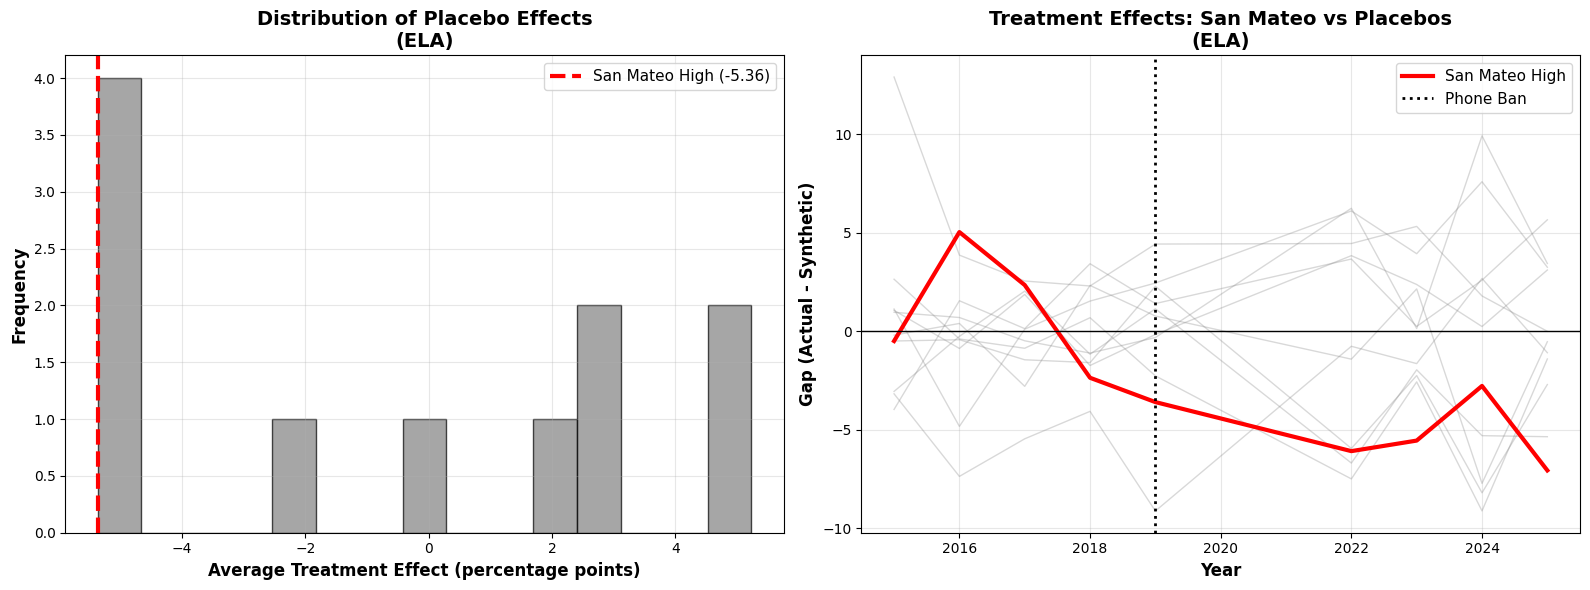


=== All Placebo Effects (ELA) ===
Burlingame High: 5.23
Mills High: 4.94
Hillsdale High: 3.05
Capuchino High: 2.90
Sequoia High: 2.40
Henry M. Gunn High: -0.20
Aragon High: -1.87
Menlo-Atherton High: -4.77
Palo Alto High: -4.82
Carlmont High: -5.14
San Mateo High: -5.36 <-- San Mateo High


In [30]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fmin_slsqp
from toolz import partial
import pandas as pd

# Helper functions
def loss_w(W, X, y):
    return np.sqrt(np.mean((y - X.dot(W))**2))

def get_w(X, y):
    w_start = [1/X.shape[1]]*X.shape[1]
    weights = fmin_slsqp(partial(loss_w, X=X, y=y),
                         np.array(w_start),
                         f_eqcons=lambda x: np.sum(x) - 1,
                         bounds=[(0.0, 1.0)]*len(w_start),
                         disp=False)
    return weights

# Settings
elapanel_clean = elapanel.drop(columns=[2021], errors='ignore')
treated_school = "San Mateo High"
pre_treatment_years = [2015, 2016, 2017, 2018, 2019]
post_treatment_years = [2022, 2023, 2024, 2025]
all_schools = elapanel_clean.index.tolist()

#####################################
#### Placebo Test - ELA
#####################################

placebo_effects = {}

for test_school in all_schools:
    # Get donor pool (everyone except the test school)
    donor_schools = [s for s in all_schools if s != test_school]

    try:
        # Get pre-treatment data
        X = elapanel_clean.loc[donor_schools, pre_treatment_years].T.values
        y = elapanel_clean.loc[test_school, pre_treatment_years].values

        # Skip if any NaN values
        if np.isnan(X).any() or np.isnan(y).any():
            continue

        # Get weights
        weights = get_w(X, y)

        # Create synthetic control
        synthetic = elapanel_clean.loc[donor_schools].T.dot(weights)
        actual = elapanel_clean.loc[test_school]

        # Calculate average post-treatment effect
        post_treatment_effect = np.mean([actual[year] - synthetic[year]
                                         for year in post_treatment_years
                                         if year in actual.index and year in synthetic.index])

        placebo_effects[test_school] = post_treatment_effect

    except:
        continue

#####################################
#### Calculate p-value - ELA
#####################################

san_mateo_effect = placebo_effects[treated_school]
all_effects = list(placebo_effects.values())

# One-tailed test: How many placebo effects are >= San Mateo's effect?
if san_mateo_effect > 0:
    p_value = np.mean([effect >= san_mateo_effect for effect in all_effects])
else:
    p_value = np.mean([effect <= san_mateo_effect for effect in all_effects])

print(f"San Mateo High treatment effect (ELA): {san_mateo_effect:.2f} percentage points")
print(f"P-value: {p_value:.3f}")

#####################################
#### Plot distribution - ELA
#####################################

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Histogram of placebo effects
ax1.hist(all_effects, bins=15, alpha=0.7, color='gray', edgecolor='black')
ax1.axvline(san_mateo_effect, color='red', linewidth=3, linestyle='--',
            label=f'San Mateo High ({san_mateo_effect:.2f})')
ax1.set_xlabel('Average Treatment Effect (percentage points)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Frequency', fontsize=12, fontweight='bold')
ax1.set_title('Distribution of Placebo Effects\n(ELA)', fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# Gap plot: Show treatment effect over time for all schools
for school, effect in placebo_effects.items():
    if school != treated_school:
        # Calculate gaps for each year
        donor_schools = [s for s in all_schools if s != school]
        X = elapanel_clean.loc[donor_schools, pre_treatment_years].T.values
        y = elapanel_clean.loc[school, pre_treatment_years].values
        weights = get_w(X, y)
        synthetic = elapanel_clean.loc[donor_schools].T.dot(weights)
        actual = elapanel_clean.loc[school]
        gaps = actual - synthetic
        ax2.plot(gaps.index, gaps.values, color='gray', alpha=0.3, linewidth=1)

# Plot San Mateo on top
donor_schools = [s for s in all_schools if s != treated_school]
X = elapanel_clean.loc[donor_schools, pre_treatment_years].T.values
y = elapanel_clean.loc[treated_school, pre_treatment_years].values
weights = get_w(X, y)
synthetic = elapanel_clean.loc[donor_schools].T.dot(weights)
actual = elapanel_clean.loc[treated_school]
gaps = actual - synthetic
ax2.plot(gaps.index, gaps.values, color='red', linewidth=3, label='San Mateo High')
ax2.axvline(x=2019, color='black', linestyle=':', linewidth=2, label='Phone Ban')
ax2.axhline(y=0, color='black', linestyle='-', linewidth=1)
ax2.set_xlabel('Year', fontsize=12, fontweight='bold')
ax2.set_ylabel('Gap (Actual - Synthetic)', fontsize=12, fontweight='bold')
ax2.set_title('Treatment Effects: San Mateo vs Placebos\n(ELA)', fontsize=14, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Show individual placebo effects
print("\n=== All Placebo Effects (ELA) ===")
for school, effect in sorted(placebo_effects.items(), key=lambda x: x[1], reverse=True):
    marker = " <-- San Mateo High" if school == treated_school else ""
    print(f"{school}: {effect:.2f}{marker}")